# Diplomatura en Ciencia de Datos UTN FRC
## Modulo 5

### Trabajo práctico 

#### Alumno: Pavelek Israel

# Sentiment Analysis sobre reviews
						
A través de este trabajo se busca poder integrar nociones y conocimientos sobre NLP vistas en el módulo, así como en los previos para generar un modelo de machine learning.
El objetivo que van a tener es construir un clasificador el cual pueda predecir si una revisión realizada por un usuario es positiva o negativa (buena o mala).
Para ello, utilizaremos un conjunto de datos que pertenece a la plataforma ​Yelp​. Esta, posee una red de usuarios, los cuales realizan opiniones sobre lugares nocturnos, espacios culturales, locales comerciales, entre otros.
El dataset a trabajar se encuentra en el siguiente ​link​. Deberán realizar un análisis de features, así como su preparación necesaria antes de iniciar el desarrollo del modelo.
						
Objetivos
Deberán generar un modelo de machine learning el cual pueda clasificar review en inglés para la plataforma Yelp. Es decir, nuestro modelo recibirá una review de un usuario, y deberá ser capaz de determinar si esta es positiva o negativa.

Dataset

Las features que contiene este dataset son las siguientes:
				
* business_id: identificador del negocio al que se está realizando la review.
* cool: cantidad de votos por haber sido una review “cool”.
* date: fecha de realización de la revisión
* funny: cantidad de votos para una revisión “divertida”.
* review_id: identificador único de revisión (ofuscado).
* stars: cantidad de estrellas otorgadas por el usuario en referencia a la review.
* text: revisión realizada por el usuario sobre un determinado negocio.
* useful: cantidad de votos recibido por los usuarios a los cuales le resultó útil la revisión.
* user_id: id del usuario en la plataforma (ofuscado)

Consideraciones

* No contamos con una variable target como pasa en problemas de la vida real. Por ello, un desafío extra que se presenta es cómo definir un target, basado en las features del dataset.
 				
* Muchas veces cuando importamos un dataset pandas infiere que valor podría ser, de no encontrar un valor conocido pone uno por defecto.Validar que los tipos de datos de las features después de importarse correspondan con su valor intrínseco es una buena práctica.

* Haga una rápida exploración de valores atípicos (outliers) del conjunto de datos. Realice los gráficos que considere pertinente para entender la naturaleza del problema.


Evaluación
 								
Para la evaluación de los modelos vamos a utilizar las siguientes métricas:
 							
* Precision
* Recall
* F1-score
* Análisis de AUC ROC

# Descripcion

# Importando Librerias

In [1]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.float_format = '{:.5f}'.format

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('white')
%matplotlib inline
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
from langdetect import DetectorFactory, detect, detect_langs
from langdetect.lang_detect_exception import LangDetectException
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\ipave\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ipave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ipave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importo datos

In [2]:
df = pd.read_csv('reviews_yelp_nn.csv.gz', compression='gzip', sep="\t", error_bad_lines=False, quotechar = '"')

C:\Users\ipave\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,EhGPj8iJDIdaHnWg9d5BgA,0,2016-04-20 14:30:53,0.00000,uJRdHLz4XNmDK5pOkWbZNA,5.00000,"Best Dim Sum in the city, their cart service i...",0.00000,POETn3fQcZ8ngLAARCATSg
1,VPcFNI-6HICR5SJM--KjNA,5,2013-05-14 03:08:12,2.00000,TlPh8jy8bt_TSGfjEw-pvA,5.00000,How... HOW did I not head down here sooner? Fo...,7.00000,oUK6Xs5dPPnP4whFeZExGg
2,ugdUuApH3pYXggW5qpbALg,0,2016-08-26 16:51:37,0.00000,GmoBAVE1pTo0kjmeKrXmLQ,4.00000,Carnitas were wonderful. First time there and ...,0.00000,SiaSUNlKQK7f57WBPmyyNw
3,3fCxmmg8nHGaE5upJWQUrw,0,2016-03-24 17:23:19,0.00000,ZHuM9P81zfuNuFZ5ThXNRg,5.00000,Great staff who are always willing to help. I ...,0.00000,PsH5Qi8R69WAlhNv8mXWRA
4,LAqbIi2TDn8BDvPB0nLVhQ,1,2012-10-25 15:02:48,0.00000,-2Ce00mfWYP20yt7k6kARg,3.00000,"This place is bigger, brighter, new so it's cl...",3.00000,r-zUIQPaHzvIyL93wQaoiQ


In [4]:
df.shape

(3342958, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342958 entries, 0 to 3342957
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   business_id  object 
 1   cool         object 
 2   date         object 
 3   funny        float64
 4   review_id    object 
 5   stars        float64
 6   text         object 
 7   useful       float64
 8   user_id      object 
dtypes: float64(3), object(6)
memory usage: 229.5+ MB


# Limpieza de datos

In [6]:
df.head(10)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,EhGPj8iJDIdaHnWg9d5BgA,0,2016-04-20 14:30:53,0.00000,uJRdHLz4XNmDK5pOkWbZNA,5.00000,"Best Dim Sum in the city, their cart service i...",0.00000,POETn3fQcZ8ngLAARCATSg
1,VPcFNI-6HICR5SJM--KjNA,5,2013-05-14 03:08:12,2.00000,TlPh8jy8bt_TSGfjEw-pvA,5.00000,How... HOW did I not head down here sooner? Fo...,7.00000,oUK6Xs5dPPnP4whFeZExGg
2,ugdUuApH3pYXggW5qpbALg,0,2016-08-26 16:51:37,0.00000,GmoBAVE1pTo0kjmeKrXmLQ,4.00000,Carnitas were wonderful. First time there and ...,0.00000,SiaSUNlKQK7f57WBPmyyNw
3,3fCxmmg8nHGaE5upJWQUrw,0,2016-03-24 17:23:19,0.00000,ZHuM9P81zfuNuFZ5ThXNRg,5.00000,Great staff who are always willing to help. I ...,0.00000,PsH5Qi8R69WAlhNv8mXWRA
4,LAqbIi2TDn8BDvPB0nLVhQ,1,2012-10-25 15:02:48,0.00000,-2Ce00mfWYP20yt7k6kARg,3.00000,"This place is bigger, brighter, new so it's cl...",3.00000,r-zUIQPaHzvIyL93wQaoiQ
5,wu5nk3pY1e_ou_Le_U52Sw,0,2010-04-20 20:43:49,2.00000,43ps1xif7NwDLEyEsc5LSw,4.00000,Sheer coincidence that I'm writing a review fo...,0.00000,MAxVtL7aoYbbQav4c3jnlw
6,v9u0NgjA4iQeKGevFnYSCA,1,2008-09-21 02:56:01,0.00000,7fPNjIHDyLX7gBzj11aZ_Q,4.00000,just got back from a weekend here......and lov...,1.00000,90nM8jGWZVvlm_5_Hbm_2Q
7,WpI5MZC3XzlTpcUOKXzCbA,1,2010-04-02 00:40:52,0.00000,_9nDhOlBBg6ZM3e0DGKn2g,5.00000,"I drive far to get to Lindo Michoacan, but it'...",2.00000,Ii7GTLNo-Uhx3meHBaBTGw
8,dB0MPu_DmFVoju48mIXx6w,0,2015-05-01 14:50:58,0.00000,0o2EtY5n2xhN6af2SfrjIQ,4.00000,Ordered 1 pizza. 3 donairs and cheezy bread at...,0.00000,N8WO5qWEQnl5ITw8ZNlYrw
9,rO3lZpVSoRMhhd0AEJBjlg,0,2018-06-26 21:01:56,0.00000,Arr0y_0xtSw3NlaiS-FPbw,2.00000,I feel conflicted about reviewing this place. ...,1.00000,4FDMtqj1Pyg3kLUzIE0f1w


Se puede ver que hay algunas observaciones muy generales para usar

In [7]:
df_work= df.drop(columns=['date', 'review_id', 'user_id','business_id'], axis=1)

In [8]:
df_work.head()

,cool,funny,stars,text,useful
0,0,0.00000,5.00000,"Best Dim Sum in the city, their cart service i...",0.00000
1,5,2.00000,5.00000,How... HOW did I not head down here sooner? Fo...,7.00000
2,0,0.00000,4.00000,Carnitas were wonderful. First time there and ...,0.00000
3,0,0.00000,5.00000,Great staff who are always willing to help. I ...,0.00000
4,1,0.00000,3.00000,"This place is bigger, brighter, new so it's cl...",3.00000


In [9]:
df_work=df_work[['cool','funny','useful','stars','text']]

In [10]:
df_work.head()

,cool,funny,useful,stars,text
0,0,0.00000,0.00000,5.00000,"Best Dim Sum in the city, their cart service i..."
1,5,2.00000,7.00000,5.00000,How... HOW did I not head down here sooner? Fo...
2,0,0.00000,0.00000,4.00000,Carnitas were wonderful. First time there and ...
3,0,0.00000,0.00000,5.00000,Great staff who are always willing to help. I ...
4,1,0.00000,3.00000,3.00000,"This place is bigger, brighter, new so it's cl..."


In [11]:
df_work.isna().sum() 

cool       3
funny      9
useful    14
stars      9
text      10
dtype: int64

In [12]:
### Como son muy pocos los valores Nulos eliminamos estas entradas
df_work=df_work.dropna()

In [13]:
df_work["cool"]=df_work["cool"].astype(float)

In [14]:
df_work.shape

(3342943, 5)

In [15]:
df_work.describe()

,cool,funny,useful,stars
count,3342943.00000,3342943.00000,3342943.00000,3342943.00000
mean,0.57720,0.48145,1.35204,3.71637
std,2.35166,2.34124,3.64557,1.46382
min,-1.00000,0.00000,-1.00000,1.00000
25%,0.00000,0.00000,0.00000,3.00000
50%,0.00000,0.00000,0.00000,4.00000
75%,0.00000,0.00000,2.00000,5.00000
max,506.00000,970.00000,1122.00000,5.00000


In [16]:
df_work.isna().sum() 

cool      0
funny     0
useful    0
stars     0
text      0
dtype: int64

# Manejo de outliers

Veamos si hay outliers en el Target.

In [17]:
quantile1, quantile3= np.percentile(df_work['useful'],[10,90])
print(quantile1,quantile3)
df_work=df_work[(df_work.useful <= quantile3) & (df_work.useful >= quantile1 )]

0.0 3.0


In [18]:
quantile1, quantile3= np.percentile(df_work['stars'],[10,90])
print(quantile1,quantile3)
df_work=df_work[(df_work.stars <= quantile3) & (df_work.stars >= quantile1 )]
df_work.shape

1.0 5.0


(3010386, 5)

In [19]:
quantile1, quantile3= np.percentile(df_work['funny'],[10,90])
print(quantile1,quantile3)
df_work=df_work[(df_work.funny <= quantile3) & (df_work.funny >= quantile1 )]
df_work.shape

0.0 1.0


(2884904, 5)

In [20]:
quantile1, quantile3= np.percentile(df_work['cool'],[10,90])
print(quantile1,quantile3)
df_work=df_work[(df_work.cool <= quantile3) & (df_work.cool >= quantile1 )]
df_work.shape

0.0 1.0


(2774962, 5)

In [21]:
df_work.describe()

,cool,funny,useful,stars
count,2774962.00000,2774962.00000,2774962.00000,2774962.00000
mean,0.14950,0.10615,0.53758,3.77843
std,0.35658,0.30803,0.81639,1.44104
min,0.00000,0.00000,0.00000,1.00000
25%,0.00000,0.00000,0.00000,3.00000
50%,0.00000,0.00000,0.00000,4.00000
75%,0.00000,0.00000,1.00000,5.00000
max,1.00000,1.00000,3.00000,5.00000


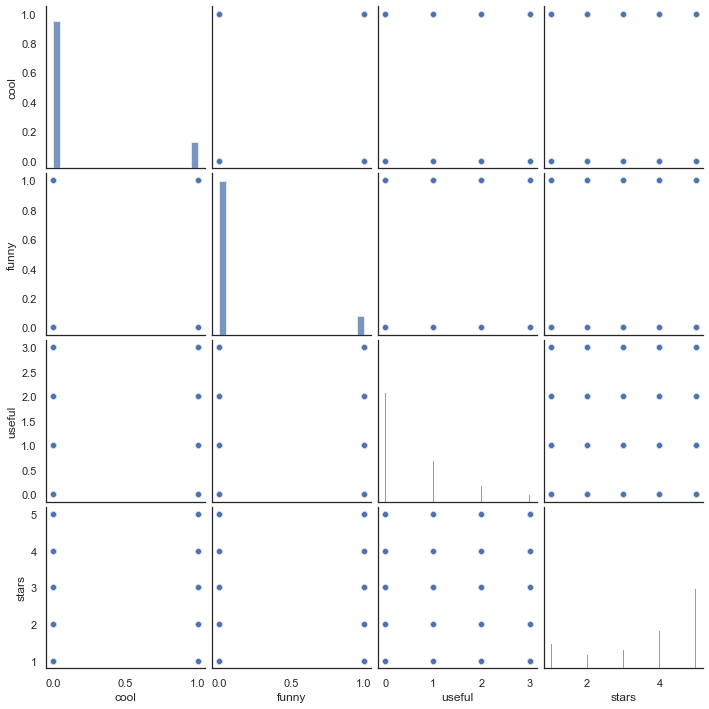

In [22]:
sns.pairplot(df_work)

In [23]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2774962 entries, 0 to 3342957
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cool    float64
 1   funny   float64
 2   useful  float64
 3   stars   float64
 4   text    object 
dtypes: float64(4), object(1)
memory usage: 127.0+ MB


In [24]:
df_work[["cool","funny","stars","useful"]]=df_work[["cool","funny","stars","useful"]].astype(int)

In [25]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2774962 entries, 0 to 3342957
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   cool    int32 
 1   funny   int32 
 2   useful  int32 
 3   stars   int32 
 4   text    object
dtypes: int32(4), object(1)
memory usage: 84.7+ MB


#### 

In [26]:
df_work["length"] = df_work.text.apply(len)


In [27]:
filter_bad_good = df_work.stars.isin([1, 5])
data_bad_good = df_work[filter_bad_good]

In [28]:
data_bad_good

,cool,funny,useful,stars,text,length
0,0,0,0,5,"Best Dim Sum in the city, their cart service i...",281
3,0,0,0,5,Great staff who are always willing to help. I ...,275
7,1,0,2,5,"I drive far to get to Lindo Michoacan, but it'...",580
11,0,0,0,5,"Dr Crezee , Beecroft and Stewart are awesome w...",118
13,0,0,1,1,What a complete disappointment! I went for lun...,714
...,...,...,...,...,...,...
3342946,0,0,2,5,The best Indian restaurant in Montreal!!!! I l...,140
3342949,0,0,0,5,My family celebrated our daughters 10th birthd...,1009
3342950,0,0,0,1,"When I saw that Matt's had four stars on here,...",1209
3342952,0,0,0,5,I went with a guest and we ordered filet migno...,346


### Normalización 

In [29]:
stemmer = nltk.RSLPStemmer()
stopwords = list(stopwords.words("english"))
punctuation = [word for word in string.punctuation]
punctuation += ['...', '  ', '\n','!','!!','!!!','!!!!']+ list("0123456789")

def remove_punctuation(serie, stopwords):
    aux = list()
    for el in serie:
        for word in stopwords:
            el = el.replace(word,' ')
        aux.append(el)
    return aux

def remove_stopwords(serie, stopwords):
    tokenizer = nltk.WordPunctTokenizer()

    result_serie= list()
    for row in serie:
        aux = list()
        text_row = tokenizer.tokenize(row.lower())
        for word in text_row:
            if word not in stopwords: # stopwords
                aux.append(word)
        result_serie.append(' '.join(aux))
    return result_serie



In [30]:
punctuation

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '...',
 '  ',
 '\n',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [31]:
data_bad_good

,cool,funny,useful,stars,text,length
0,0,0,0,5,"Best Dim Sum in the city, their cart service i...",281
3,0,0,0,5,Great staff who are always willing to help. I ...,275
7,1,0,2,5,"I drive far to get to Lindo Michoacan, but it'...",580
11,0,0,0,5,"Dr Crezee , Beecroft and Stewart are awesome w...",118
13,0,0,1,1,What a complete disappointment! I went for lun...,714
...,...,...,...,...,...,...
3342946,0,0,2,5,The best Indian restaurant in Montreal!!!! I l...,140
3342949,0,0,0,5,My family celebrated our daughters 10th birthd...,1009
3342950,0,0,0,1,"When I saw that Matt's had four stars on here,...",1209
3342952,0,0,0,5,I went with a guest and we ordered filet migno...,346


### EDA


In [ ]:
g = sns.FacetGrid(data_bad_good,col='stars')
g.map(plt.hist,'text length')

In [ ]:
sns.boxplot(x='stars',y='text length',data=data_bad_good,palette='rainbow')


In [ ]:
sns.countplot(x='stars',data=data_bad_good,palette='rainbow')


In [ ]:
stars = data_bad_good.groupby('stars').mean()
stars

In [ ]:
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)


In [ ]:
data_bad_good.stars.value_counts().plot(kind='bar')
plt.box(False)

In [ ]:
sns.kdeplot(x ='length', hue='stars',data= data_bad_good)
plt.box(False)

In [32]:
data_bad_good.text = data_bad_good.text.str.lower()
data_bad_good.text = remove_stopwords(data_bad_good.text, punctuation)
data_bad_good.text = remove_stopwords(data_bad_good.text, stopwords)

C:\Users\ipave\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:

data_bad_good

,cool,funny,useful,stars,text,length
0,0,0,0,5,best dim sum city cart service great offer big...,281
3,0,0,0,5,great staff always willing help turn leased ca...,275
7,1,0,2,5,drive far get lindo michoacan worth food aweso...,580
11,0,0,0,5,dr crezee beecroft stewart awesome without dou...,118
13,0,0,1,1,complete disappointment went lunch year old or...,714
...,...,...,...,...,...,...
3342946,0,0,2,5,best indian restaurant montreal love saag pane...,140
3342949,0,0,0,5,family celebrated daughters 10th birthday 30pm...,1009
3342950,0,0,0,1,saw matt four stars anticipating something pre...,1209
3342952,0,0,0,5,went guest ordered filet mignon potatoes cream...,346


In [ ]:

vectorize = CountVectorizer()

X = vectorize.fit_transform(data_bad_good.text)
Y = data_bad_good.stars.map({5: 1, 1: 0}).values

In [ ]:
X

In [ ]:
cv = CountVectorizer()
X = cv.fit_transform(X)

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

### Modelling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

model = MultinomialNB()

model.fit(X_train, y_train)

In [ ]:
predictions = model.predict(X_test)


In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
confusion_matrix(y_test, predictions)

In [34]:
data_bad_good['text'].shape

(1657219,)

In [35]:
data_bad_good[data_bad_good['text'].isnull()] #>10

,cool,funny,useful,stars,text,length


In [36]:
data_bad_good[data_bad_good['text']==""] #>10


,cool,funny,useful,stars,text,length
209602,1,1,1,1,,1
623133,0,0,0,1,,1
756966,0,0,0,5,,1
785320,0,0,0,5,,1
825669,0,0,0,1,,2
841221,0,0,0,1,,1
861917,0,0,1,1,,1
879877,0,0,0,1,,17
1080762,0,0,1,1,,2
1721207,0,0,0,1,,1


In [37]:
data_bad_good["length"] = data_bad_good.text.apply(len)


C:\Users\ipave\AppData\Local\Temp/ipykernel_24720/473009959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bad_good["length"] = data_bad_good.text.apply(len)


In [38]:
data_bad_good[data_bad_good['length']<=3] #>10


,cool,funny,useful,stars,text,length
114716,0,0,0,1,bad,3
209602,1,1,1,1,,0
354386,0,0,0,5,:),2
623133,0,0,0,1,,0
697343,0,1,0,1,b,1
756966,0,0,0,5,,0
785320,0,0,0,5,,0
825669,0,0,0,1,,0
841221,0,0,0,1,,0
861917,0,0,1,1,,0


In [39]:
data_bad_good

,cool,funny,useful,stars,text,length
0,0,0,0,5,best dim sum city cart service great offer big...,160
3,0,0,0,5,great staff always willing help turn leased ca...,178
7,1,0,2,5,drive far get lindo michoacan worth food aweso...,313
11,0,0,0,5,dr crezee beecroft stewart awesome without dou...,89
13,0,0,1,1,complete disappointment went lunch year old or...,426
...,...,...,...,...,...,...
3342946,0,0,2,5,best indian restaurant montreal love saag pane...,102
3342949,0,0,0,5,family celebrated daughters 10th birthday 30pm...,575
3342950,0,0,0,1,saw matt four stars anticipating something pre...,739
3342952,0,0,0,5,went guest ordered filet mignon potatoes cream...,232


In [40]:
#data_bad_good[data_bad_good['length']<=3] #>10

data_bad_good=data_bad_good[data_bad_good['length']>=3]
data_bad_good

,cool,funny,useful,stars,text,length
0,0,0,0,5,best dim sum city cart service great offer big...,160
3,0,0,0,5,great staff always willing help turn leased ca...,178
7,1,0,2,5,drive far get lindo michoacan worth food aweso...,313
11,0,0,0,5,dr crezee beecroft stewart awesome without dou...,89
13,0,0,1,1,complete disappointment went lunch year old or...,426
...,...,...,...,...,...,...
3342946,0,0,2,5,best indian restaurant montreal love saag pane...,102
3342949,0,0,0,5,family celebrated daughters 10th birthday 30pm...,575
3342950,0,0,0,1,saw matt four stars anticipating something pre...,739
3342952,0,0,0,5,went guest ordered filet mignon potatoes cream...,232


In [ ]:
def get_review_language(row):
    try:
        language = detect(row)
    except:
        language = "error"
        
    return language

data_bad_good["language"] = data_bad_good['text'].apply(get_review_language)


In [ ]:
from datetime import datetime

print("Habia empezado 00:47")

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Termino=", current_time)

data_bad_good

In [ ]:

def get_review_language(row):
    try:
        language = TextBlob(row)
        return language.detect_language()
    except:
        return "error"
        
    
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("El segundo empezó =", current_time)

    
data_bad_good["language"] = data_bad_good['text'].apply(get_review_language)


data_bad_good

In [ ]:
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Termino =", current_time)


In [ ]:
data_bad_good["language"].value_counts()


In [ ]:
data_bad_good["language"].value_counts(normalize=True)


# Valores Nulos

In [ ]:

DetectorFactory.seed = 0
def is_english(text):
    try:
        if detect(text) != "en":
            return False
    except LangDetectException:
        return False
    return True

In [ ]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

from sklearn.metrics import classification_report
print(classification_report(ytrue, langdetect_preds_binary))
print(classification_report(ytrue, spacy_preds_binary))
print(classification_report(ytrue, langid_preds_binary))
print(classification_report(ytrue, fasttext_preds_binary))

# Split Train and Test data


# Training Model